***
*Workshop:* [TTSM (Technology & Thought in Sonic Media) summer school 2023](https://ttsm.link/) - Symbolic Music Data Processing and Generation

*Instructor:* Jingwei Liu (Music department, UC San Diego)
***

# <span style="background-color:darkorange; color:white; padding:2px 6px">Tutorial</span> 


# Symbolic Music Generation by RNN

Based on the data processing techniques we developed in the first workshop, in our second workshop, we will use the processed data to train a neural network for music generation. As our input is processed as sequential monophonic pieces, the most suitable neural network model would be autoregressive model, such as RNN.

In this tutorial we will build our own RNN model by writing the formulas and functions from scratch, instead of applying a pre-built library. This exercise will give you a deeper understanding of the mechanism of neural networks, and also demonstrate how to flexibly design and train neural networks rather than being constrained by the settings of other programmers.

In [1]:
import numpy as np
import pandas as pd
from music21 import *
import py_midicsv as pm
import random
import csv
from pathlib import Path
import os

We use `PyTorch` as our machine learning platform.

In [2]:
import torch
torch.cuda.is_available()

True

*Package introduction*
- [PyTorch](https://pytorch.org/docs/stable/index.html) is an optimized tensor library for deep learning using GPUs and CPUs.

In [3]:
dev = torch.device("cuda") # operate on GPU "cuda" or CPU "cpu"

## Part 1: Statistics of Dataset

We pre-processed 10 selected files from [Dave's J.S. Bach Page](http://www.jsbach.net/midi/midi_solo_cello.html) with uniform time signature (4/4) and BPM (80). The data is encoded as "Note, Duration, Structure level". The notes are concatenated sequentially without rest, and the pieces are monophonic, which means there are no chords or simultaneous notes.

In [4]:
folder = Path('Selected_files/Processed').rglob('*.csv')
file_list = []
for x in folder:
    file = x
    dirname = os.path.dirname(x)
    basename = os.path.basename(x)
    name = os.path.splitext(basename)[0]
    filename = os.path.join(dirname, basename)
    file_list.append(basename)
    print(basename)

cs1-1pre.csv
cs1-2all.csv
cs2-2all.csv
cs3-2all.csv
cs3-5bou.csv
cs4-1pre_part1.csv
cs4-1pre_part2.csv
cs4-2all.csv
cs4-5bou.csv
cs5-2all.csv


In [5]:
file_list

['cs1-1pre.csv',
 'cs1-2all.csv',
 'cs2-2all.csv',
 'cs3-2all.csv',
 'cs3-5bou.csv',
 'cs4-1pre_part1.csv',
 'cs4-1pre_part2.csv',
 'cs4-2all.csv',
 'cs4-5bou.csv',
 'cs5-2all.csv']

We have 10 files in the dataset.

In [6]:
ALL = pd.DataFrame(columns=['Note','Duration_32th','Structure_level'])
folder = Path('Selected_files/Processed').rglob('*.csv')
for x in folder:
    Single = pd.read_csv(x, sep=",",names = ["Note", "Duration_32th", "Structure_level"])
    ALL = pd.concat([ALL, Single])
ALL = ALL.reset_index(drop=True)
ALL = ALL.astype({
    'Note': np.int64,
    'Duration_32th': np.int64,
    'Structure_level': np.int64
})
ALL

,Note,Duration_32th,Structure_level
0,43,2,0
1,50,2,3
2,59,2,2
3,57,2,3
4,59,2,1
...,...,...,...
7925,60,6,0
7926,55,2,3
7927,51,6,1
7928,48,2,3


There are 7930 notes in the dataset in total.

In [7]:
np.unique(ALL['Note'])

array([36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67],
      dtype=int64)

In [8]:
len(np.unique(ALL['Note']))

32

In [9]:
np.shape(np.unique(ALL['Note']))

(32,)

The note's range is $[36, 67]$, 32 notes in total. We encode the notes as 32-dimensional vectors:

In [10]:
def note_one_hot(note, dev):
    """
    Arguments:
    note -- numpy array of shape (n, )
    
    Returns:
    note_vt -- torch tensor of shape (32, n)
    """
    l = len(note)
    note_vt = torch.zeros([32,l], device = dev)
    note_vt[note - 36,np.arange(l)] = 1
    
    return note_vt

In [11]:
notes = np.array(ALL['Note'][0:5])
notes

array([43, 50, 59, 57, 59], dtype=int64)

In [12]:
note_one_hot(notes, dev)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], device='cuda:0')

In [13]:
np.unique(ALL['Duration_32th'])

array([ 1,  2,  4,  5,  6,  8, 10, 12, 14, 20], dtype=int64)

In [14]:
len(np.unique(ALL['Duration_32th']))

10

There are 10 types of durations. Similarly, we encode the duration as one hot vectors of dimension 10.

In [15]:
dur_list = np.unique(ALL['Duration_32th'])
dur_list

array([ 1,  2,  4,  5,  6,  8, 10, 12, 14, 20], dtype=int64)

In [16]:
dur_dict = dict(zip(dur_list, np.arange(len(dur_list))))
dur_dict

{1: 0, 2: 1, 4: 2, 5: 3, 6: 4, 8: 5, 10: 6, 12: 7, 14: 8, 20: 9}

In [17]:
list(map(dur_dict.get,[5,8,6,5]))

[3, 5, 4, 3]

In [18]:
def dur_one_hot(dur,dur_list,dev):
    """
    Arguments:
    dur -- numpy array of shape (n, )
    
    Returns:
    dur_vt -- torch tensor of shape (10, n)
    """
    l = len(dur)
    dur_vt = torch.zeros([10,l], device = dev)
    dur_index = np.array(list(map(dur_dict.get,dur)))
    dur_vt[dur_index,np.arange(l)] = 1
    
    return dur_vt

In [19]:
dur = np.array(ALL['Duration_32th'][-5:])
dur

array([ 6,  2,  6,  2, 12], dtype=int64)

In [20]:
dur_one_hot(dur,dur_list,dev)

tensor([[0., 0., 0., 0., 0.],
        [0., 1., 0., 1., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], device='cuda:0')

In [21]:
np.unique(ALL['Structure_level'])

array([0, 1, 2, 3, 4], dtype=int64)

In [22]:
len(np.unique(ALL['Structure_level']))

5

There are 5 types of structure levels. Since the structure level only indicates the relative position of the notes in time, which is determined by the duration, it works as additional information rather than a predictive term in our design.

In [23]:
def lev_one_hot(lev, dev):
    """
    Arguments:
    lev -- numpy array of shape (n, )
    
    Returns:
    lev_vt -- torch tensor of shape (5, n)
    """
    l = len(lev)
    lev_vt = torch.zeros([5,l], device = dev)
    lev_vt[lev,np.arange(l)] = 1
    
    return lev_vt

In [24]:
lev = np.array(ALL['Structure_level'][-5:])
lev

array([0, 3, 1, 3, 1], dtype=int64)

In [25]:
lev_one_hot(lev, dev)

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0.],
        [0., 1., 0., 1., 0.],
        [0., 0., 0., 0., 0.]], device='cuda:0')

There could possibly be 32 x 10 x 5 = 1600 combinations if the three factors are considered indepent. However,

In [26]:
np.unique(np.array(ALL),axis = 0)

array([[36,  1,  2],
       [36,  2,  0],
       [36,  2,  1],
       ...,
       [67,  4,  0],
       [67,  4,  1],
       [67,  4,  2]], dtype=int64)

In [27]:
len(np.unique(np.array(ALL),axis = 0))

357

There are far less combinations in the dataset. Even if we only take the note and duration, it would be

In [28]:
np.unique(np.array(ALL[['Note','Duration_32th']]),axis = 0)

array([[36,  1],
       [36,  2],
       [36,  4],
       [36,  6],
       [36,  8],
       [36, 20],
       [37,  2],
       [37,  5],
       [37,  8],
       [38,  1],
       [38,  2],
       [38,  4],
       [38,  6],
       [39,  1],
       [39,  2],
       [39,  4],
       [39,  8],
       [40,  2],
       [40,  4],
       [40,  6],
       [40, 12],
       [41,  1],
       [41,  2],
       [41,  4],
       [42,  2],
       [42,  4],
       [42, 12],
       [43,  1],
       [43,  2],
       [43,  4],
       [43,  6],
       [43, 14],
       [44,  1],
       [44,  2],
       [44,  4],
       [44,  6],
       [44, 10],
       [45,  1],
       [45,  2],
       [45,  4],
       [45,  6],
       [46,  1],
       [46,  2],
       [46,  4],
       [46,  6],
       [46,  8],
       [46, 10],
       [46, 12],
       [47,  1],
       [47,  2],
       [47,  4],
       [47,  6],
       [47,  8],
       [48,  1],
       [48,  2],
       [48,  4],
       [48,  6],
       [48,  8],
       [48, 10

In [29]:
len(np.unique(np.array(ALL[['Note','Duration_32th']]),axis = 0))

159

The exaustive possibilities are 320.

The problem is, if we compress [Note, Duration_32th, Structure_level] (or just [Note, Duration_32th] in the simplest case) into one token and encode it with one hot vector, we can come up with a 357-dimension vector based on the dataset. This representation is compact and clean but it lacks the ability of generalization. Such representation can only generate D2(38) with short durations but not any quarter-note D2 or half-note D2. If we expand the vector dimension to comprise all possibilities, 1600-dimension, then many of the entries won't be covered in training. Then in generating, any generation out of the dataset would possibly be treated as an error that is not trained by the neural network.

One way is to augment the data to cover all keys so the dataset could cover more out of the 1600 combinations. This method also has its limitation. Obviously, translating a corpus up or down would possibly introduce notes out of the range [36,67]. If we limit ourselves inside this range, the data won't be augmented much so the previously stated problem still exists. Therefore, we may resort to new ways for the music generation.

## Part 2: Data Augmentation by Key Translation

Now let's take a look at a single file.

In [30]:
file_list

['cs1-1pre.csv',
 'cs1-2all.csv',
 'cs2-2all.csv',
 'cs3-2all.csv',
 'cs3-5bou.csv',
 'cs4-1pre_part1.csv',
 'cs4-1pre_part2.csv',
 'cs4-2all.csv',
 'cs4-5bou.csv',
 'cs5-2all.csv']

In [31]:
Single = pd.read_csv('Selected_files/Processed/'+file_list[5], sep=",",names = ["Note", "Duration_32th", "Structure_level"])
print(Single)

     Note  Duration_32th  Structure_level
0      39              4                0
1      63              4                2
2      58              4                1
3      55              4                2
4      58              4                1
..    ...            ...              ...
380    55              4                1
381    46              4                2
382    50              4                1
383    43              4                2
384    37              8                0

[385 rows x 3 columns]


In [32]:
n = len(Single)
n

385

In this tutorial we won't use batch and vectorization, the methods that are developed to scaling the training to large dataset and speed up computation. As we have a rather small dataset at hand and our purpose is to understand and explore the methods of machine learning, instead of industrial application, we will make the training as flexible as we can.

In [33]:
np.unique(Single['Note'])

array([36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65], dtype=int64)

First, we perform data augmentation by key translation.

In [34]:
folder = Path('Selected_files/Processed').rglob('*.csv')
for x in folder:
    basename = os.path.basename(x)
    name = os.path.splitext(basename)[0]
    
    Single = pd.read_csv(x, sep=",",names = ["Note", "Duration_32th", "Structure_level"])
    notes = np.unique(Single['Note'])
    low = notes[0]
    high = notes[-1]
    for i in range(1,low-35):
        Single['Note'] = np.array(Single['Note'])-1
        Single.to_csv('Selected_files/Augment/'+name+"_"+str(-i)+'.csv', header=False,index=False)
    for i in range(1,68-high):
        Single['Note'] = np.array(Single['Note'])+1
        Single.to_csv('Selected_files/Augment/'+name+"_"+str(i)+'.csv', header=False,index=False)

We augmented 23 files. The dataset consists 33 files in total.

The next step is segmentation. Remember that RNN is not in fixed length. People usually use fixed-window segmentation to apply RNN to large-scale ML tasks to save computational time. However, it's not inherent for autoregressive neural networks and it's not required. We use flexible windows in our model to avoid this rigidity.

We generate a window of arbitrary length within range [3,10), so that the window length is different every time.

In [35]:
np.random.randint(3,10)

3

## Part 3: Recurrent Neural Network

A recurrent neural network can be seen as the repeated use of a single cell. You are first going to implement the computations for a single time-step. The following figure describes the operations for a single time-step of an RNN cell. 

<img src="Figure/rnn_step_forward.png" style="width:700px;height:300px;">
<caption><center> Figure 1: Basic RNN cell. Takes as input $x^{\langle t \rangle}$ (current input) and $a^{\langle t - 1\rangle}$ (previous hidden state containing information from the past), and outputs $a^{\langle t \rangle}$ which is given to the next RNN cell and also used to predict $\hat{y}^{\langle t \rangle}$ </center></caption>

<img src="Figure/rnn.png" style="width:450;height:300px;">
<caption><center> Figure 2: Recurrent Neural Network  </center></caption>

At each time-step, the RNN tries to predict what is the index of the next (note, duration, structure) tuple given the index of the previous tuple. The dataset $X = (x^{\langle 1 \rangle}, x^{\langle 2 \rangle}, ..., x^{\langle T_x \rangle})$ is a list of indices in the training set, while $Y = (y^{\langle 1 \rangle}, y^{\langle 2 \rangle}, ..., y^{\langle T_x \rangle})$ is such that at every time-step $t$, we have $y^{\langle t \rangle} = x^{\langle t+1 \rangle}$. 

In our case, we have three inputs, note $x_n^{<t>}$, duration $x_d^{<t>}$ and additional information structural level $x_l^{<t>}$; two outputs, note distribution $y_n^{<t>}$ and duration distribution $y_d^{<t>}$. Sampling from the output distributions, we get one hot vectors $z_n^{<t>}$ and$z_d^{<t>}$, which align with the next inputs $x_n^{<t+1>}$ and $x_d^{<t+1>}$. We modify the neural network as follows:

$$ \begin{align}
a^{<t>} &= tanh(W_{ax} x^{<t>} + W_{aa} a^{<t-1>} + b_a) \quad \text{where} \ x = [x_n, x_d, x_l]^T \\
y_d^{<t>} &= softmax(W_{y_da}a^{<t>} + b_{y_d}) \\
z_d^{<t>} &= sample(y_d^{<t>}) \\
y_n^{<t>} &= softmax(W_{y_n,a + y_d}[a^{<t>}, z_d^{<t>}]^T + b_{y_n}) \\
z_n^{<t>} &= sample(y_n^{<t>})
\end{align}$$

The nonlinear functions are [tanh](https://mathworld.wolfram.com/HyperbolicTangent.html) and [softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html).

### 1) Parameter Initialization

Random initialize parameters in range [-0.5,0.5)

In [155]:
def random_init(d_a,d_xn,d_xd,d_xl, dev):
    """
    Arguments:
    d_a -- dimension of tensor a (default: 20)
    d_xn -- dimension of note input x_n (default: 23)
    d_xd -- dimension of duration input x_d (default: 10)
    d_xl -- dimension of structural level input x_l (default: 5)
    dev -- torch.device("cuda")  # operate on GPU
    
    Returns:
    Parameter matrices W's and bias b's
    """
    
    W_ax = torch.rand(d_a, d_xn + d_xd + d_xl, device = dev)-0.5
    W_ax.requires_grad_(True)
    W_aa = torch.rand(d_a, d_a, device = dev)-0.5
    W_aa.requires_grad_(True)
    b_a = torch.rand(d_a, 1, device = dev)-0.5
    b_a.requires_grad_(True)
    W_yd = torch.rand(d_xd, d_a, device = dev)-0.5
    W_yd.requires_grad_(True)
    b_yd = torch.rand(d_xd, 1, device = dev)-0.5
    b_yd.requires_grad_(True)
    W_yn = torch.rand(d_xn, d_a+d_xd, device = dev)-0.5
    W_yn.requires_grad_(True)
    b_yn = torch.rand(d_xn, 1, device = dev)-0.5
    b_yn.requires_grad_(True)
    
    return W_ax, W_aa, b_a, W_yd, b_yd, W_yn, b_yn

In [194]:
d_a = 20
d_xn = 32
d_xd = 10
d_xl = 5
[W_ax, W_aa, b_a, W_yd, b_yd, W_yn, b_yn] = random_init(d_a,d_xn,d_xd,d_xl, dev)
print('W_ax:', W_ax.shape)
print('W_aa:', W_aa.shape)
print('b_a:', b_a.shape)
print('W_yd:', W_yd.shape)
print('b_yd:', b_yd.shape)
print('W_yn:', W_yn.shape)
print('b_yn:', b_yn.shape)
print('b_yd:', b_yd)

W_ax: torch.Size([20, 47])
W_aa: torch.Size([20, 20])
b_a: torch.Size([20, 1])
W_yd: torch.Size([10, 20])
b_yd: torch.Size([10, 1])
W_yn: torch.Size([32, 30])
b_yn: torch.Size([32, 1])
b_yd: tensor([[ 0.4345],
        [ 0.3207],
        [-0.4836],
        [-0.3111],
        [ 0.4616],
        [-0.4564],
        [-0.0151],
        [ 0.2817],
        [-0.0327],
        [-0.1629]], device='cuda:0', requires_grad=True)


### 2) Basic Functions

We will design our own RNN from scratch and write our own formulas instead of using a standard package. `PyTorch` is used for its `autograd` function, which means once we write down the forward pass, the loss derivatives are automatically computed, which saves the labor for manual backpropagation.

In [195]:
def softmax(x):
    e_x = torch.exp(x - torch.max(x))
    return e_x / torch.sum(e_x)

In [196]:
def forward_duration(x_n, x_d, x_l, a_prev, W_ax, W_aa, b_a, W_yd, b_yd):
    """
    One step prediction in Figure 1
    
    Arguments:
    x_n -- note input one-hot torch tensor of shape (32,1)
    x_d -- duration input one-hot torch tensor of shape (10,1)
    x_l -- structure level input one-hot torch tensor of shape (5,1)
    a_prev -- previous memory a, torch tensor of shape (20,1)
    Parameters -- W_ax: torch.Size([20, 47])
                W_aa: torch.Size([20, 20])
                b_a: torch.Size([20, 1])
                W_yd: torch.Size([10, 20])
                b_yd: torch.Size([10, 1])
    
    Returns:
    a_next -- next memory a, torch tensor of shape (20,1)
    y_d -- duration distribution torch tensor of shape (10,1)
    """
    x = torch.cat((x_n, x_d, x_l),0)
    x = x.type(torch.float32)
    a_next = torch.tanh(torch.matmul(W_ax,x) + torch.matmul(W_aa,a_prev) + b_a)
    y_d = softmax(torch.matmul(W_yd,a_next) + b_yd)
    
    return a_next, y_d

In [197]:
def forward_note(z_d, a_next, W_yn, b_yn):
    """
    One step prediction in Figure 1
    
    Arguments:
    z_d -- sampled duration one-hot torch tensor of shape (10,1)
    a_next -- updated memory a, torch tensor of shape (20,1)
    Parameters -- W_yn: torch.Size([32, 30])
                b_yn: torch.Size([32, 1])
    
    Returns:
    y_n -- note distribution torch tensor of shape (32,1)
    """
    
    a_aug = torch.cat((a_next, z_d),0)
    y_n = softmax(torch.matmul(W_yn,a_aug) + b_yn)
    
    return y_n

In [199]:
x_n = torch.zeros(32,1, device = dev)
x_n[3] = 1
x_d = torch.zeros(10,1, device = dev)
x_n[3] = 1
x_l = torch.zeros(5,1, device = dev)
x_l[3] = 1
a_prev = torch.zeros(20,1, device = dev)
[a_next, y_d] = forward_duration(x_n, x_d, x_l, a_prev, W_ax, W_aa, b_a, W_yd, b_yd)
z_d = x_d
y_n = forward_note(z_d, a_next, W_yn, b_yn)
print("y_d:", y_d)
# print("y_n:", y_n)

y_d: tensor([[0.0868],
        [0.1498],
        [0.1475],
        [0.0678],
        [0.0583],
        [0.0188],
        [0.1033],
        [0.1495],
        [0.0484],
        [0.1697]], device='cuda:0', grad_fn=<DivBackward0>)
y_n: tensor([[0.0403],
        [0.0139],
        [0.0366],
        [0.0343],
        [0.0209],
        [0.0232],
        [0.0095],
        [0.0196],
        [0.0360],
        [0.0265],
        [0.0610],
        [0.0134],
        [0.0139],
        [0.0459],
        [0.0340],
        [0.0103],
        [0.0166],
        [0.0068],
        [0.0080],
        [0.0126],
        [0.0482],
        [0.0548],
        [0.0290],
        [0.0202],
        [0.0359],
        [0.0577],
        [0.0379],
        [0.0441],
        [0.0142],
        [0.0885],
        [0.0667],
        [0.0193]], device='cuda:0', grad_fn=<DivBackward0>)


We use cross-entropy loss,

$$
L = -\sum_i p_i log(\hat{p}_i)
$$

The target distribution $p_i$ is a one-hot vector, let's say it equals to 1 at position $k$, then
$$ L = -log(\hat{p}_k)$$

Since we have two predictions $y_d$ and $y_n$, we assign propotion $w$ to the two cross-entropy losses $L_d$ and $L_n$ to weight them in the final expression

$$
L = wL_d + (1-w)L_n
$$

In [200]:
def forward_pass(X_n, X_d, X_l, a0, W_ax, W_aa, b_a, W_yd, b_yd, W_yn, b_yn, window_size,w):
    """
    Arguments:
    X_n -- note input one-hot torch tensor of shape (32, window_size)
    X_d -- duration input one-hot torch tensor of shape (10, window_size)
    X_l -- structure level input one-hot torch tensor of shape (5, window_size)
    a0 -- initial memory a, torch tensor of shape (20,1)
    Parameters -- W_ax: torch.Size([20, 47])
                W_aa: torch.Size([20, 20])
                b_a: torch.Size([20, 1])
                W_yd: torch.Size([10, 20])
                b_yd: torch.Size([10, 1])
                W_yn: torch.Size([32, 30])
                b_yn: torch.Size([32, 1])
    window_size -- the size of the input chunk
    w -- weight of duration loss in the sum of duration loss and note loss
    
    Returns:
    L -- total loss
    """
    a_prev = a0
    
    # initialize loss to 0
    l_d = 0
    l_n = 0
    
    for i in range(window_size-1):
        x_n = X_n[:,i:i+1]  # note input one-hot torch tensor of shape (32,1)
        x_d = X_d[:,i:i+1]  # duration input one-hot torch tensor of shape (10,1)
        x_l = X_l[:,i:i+1]  # structure level input one-hot torch tensor of shape (5,1)
        [a_next, y_d] = forward_duration(x_n, x_d, x_l, a_prev, W_ax, W_aa, b_a, W_yd, b_yd)
        z_d = X_d[:,i+1:i+2]
        y_n = forward_note(z_d, a_next, W_yn, b_yn)
        
        # Loss
        x_d_next = X_d[:,i+1:i+2]
        index = torch.where(x_d_next==1)
        l_d -= y_d[index].log()
        
        x_n_next = X_n[:,i+1:i+2]
        index = torch.where(x_n_next==1)
        l_n -= y_n[index].log()
        
        a_prev = a_next
        
    
    L = (w*l_d + (1-w)*l_n)/window_size
    
    return L,a_next

In [48]:
def parameter_update(loss,lr, W_ax, W_aa, b_a, W_yd, b_yd, W_yn, b_yn):
    """
    Arguments:
    loss -- torch tensor of shape [1]
    lr -- learning rate
    Parameters -- W_ax: torch.Size([20, 47])
                W_aa: torch.Size([20, 20])
                b_a: torch.Size([20, 1])
                W_yd: torch.Size([10, 20])
                b_yd: torch.Size([10, 1])
                W_yn: torch.Size([32, 30])
                b_yn: torch.Size([32, 1])
    window_size -- the size of the input chunk
    w -- weight of duration loss in the sum of duration loss and note loss
    
    Returns:
    
    """
    loss.backward()
    with torch.no_grad():
        W_ax -= lr * W_ax.grad # W_ax = W_ax - lr * W_ax.grad
        W_ax.grad.zero_()
        W_aa -= lr * W_aa.grad
        W_aa.grad.zero_()
        b_a -= lr * b_a.grad
        b_a.grad.zero_()
        W_yd -= lr * W_yd.grad
        W_yd.grad.zero_()
        b_yd -= lr * b_yd.grad
        b_yd.grad.zero_()
        W_yn -= lr * W_yn.grad
        W_yn.grad.zero_()
        b_yn -= lr * b_yn.grad
        b_yn.grad.zero_()
        
            
    return W_ax, W_aa, b_a, W_yd, b_yd, W_yn, b_yn

### 3) Function Test

Let's test the funtions:

In [201]:
Single = pd.read_csv('Selected_files/Processed/'+file_list[9], sep=",",names = ["Note", "Duration_32th", "Structure_level"])
print(Single)

     Note  Duration_32th  Structure_level
0      60              2                3
1      60             10                0
2      58              2                3
3      56              2                2
4      55              2                3
..    ...            ...              ...
681    60              6                0
682    55              2                3
683    51              6                1
684    48              2                3
685    60             12                1

[686 rows x 3 columns]


In [212]:
window_size = np.random.randint(3,10)
window_size

6

In [213]:
notes = np.array(Single['Note'][0:window_size])
notes

array([60, 60, 58, 56, 55, 56], dtype=int64)

In [214]:
X_n = note_one_hot(notes, dev)
X_n

tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0

In [215]:
dur = np.array(Single['Duration_32th'][0:window_size])
dur

array([ 2, 10,  2,  2,  2,  6], dtype=int64)

In [216]:
X_d = dur_one_hot(dur,dur_list,dev)
X_d

tensor([[0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 1., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]], device='cuda:0')

In [217]:
lev = np.array(Single['Structure_level'][0:window_size])
lev

array([3, 0, 3, 2, 3, 1], dtype=int64)

In [218]:
X_l = lev_one_hot(lev, dev)
X_l

tensor([[0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0.],
        [1., 0., 1., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0.]], device='cuda:0')

In [219]:
a = torch.zeros([20,1], device = dev)
w = 0.3

In [220]:
print('X_n:', X_n.dtype)
print('X_d:', X_d.dtype)
print('X_l:', X_l.dtype)
print('a:', a.dtype)

print('W_ax:', W_ax.dtype)
print('W_aa:', W_aa.dtype)
print('b_a:', b_a.dtype)
print('W_yd:', W_yd.dtype)
print('b_yd:', b_yd.dtype)
print('W_yn:', W_yn.dtype)
print('b_yn:', b_yn.dtype)

X_n: torch.float32
X_d: torch.float32
X_l: torch.float32
a: torch.float32
W_ax: torch.float32
W_aa: torch.float32
b_a: torch.float32
W_yd: torch.float32
b_yd: torch.float32
W_yn: torch.float32
b_yn: torch.float32


In [221]:
loss,a = forward_pass(X_n, X_d, X_l, a, W_ax, W_aa, b_a, W_yd, b_yd, W_yn, b_yn, window_size,w)
print('loss:',loss)
print('a:',a)

loss: tensor([2.4537], device='cuda:0', grad_fn=<DivBackward0>)
a: tensor([[-0.3441],
        [ 0.9837],
        [ 0.7509],
        [-0.1064],
        [ 0.8168],
        [ 0.9641],
        [-0.2327],
        [-0.5799],
        [ 0.2957],
        [ 0.8394],
        [ 0.2604],
        [ 0.8304],
        [ 0.1909],
        [ 0.2147],
        [-0.9762],
        [-0.0619],
        [-0.3396],
        [ 0.3215],
        [-0.5679],
        [ 0.9125]], device='cuda:0', grad_fn=<TanhBackward0>)


In [222]:
loss.backward()

In [223]:
print('b_yd.grad:', b_yd.grad)

b_yd.grad: tensor([[ 0.0163],
        [-0.0609],
        [ 0.0293],
        [ 0.0091],
        [-0.0284],
        [ 0.0026],
        [-0.0215],
        [ 0.0134],
        [ 0.0157],
        [ 0.0244]], device='cuda:0')


### 4) Training on the Dataset

In [224]:
folder = Path('Selected_files').rglob('*.csv')
num = 0
for x in folder:
    basename = os.path.basename(x)
    num += 1
    print(basename)
print('Number of files:', num)

cs1-2all_-1.csv
cs1-2all_-2.csv
cs2-2all_-1.csv
cs2-2all_-2.csv
cs2-2all_1.csv
cs2-2all_2.csv
cs3-5bou_-1.csv
cs3-5bou_-2.csv
cs3-5bou_-3.csv
cs3-5bou_-4.csv
cs3-5bou_1.csv
cs3-5bou_2.csv
cs4-1pre_part1_1.csv
cs4-1pre_part1_2.csv
cs4-1pre_part2_1.csv
cs4-1pre_part2_2.csv
cs4-1pre_part2_3.csv
cs4-1pre_part2_4.csv
cs4-2all_-1.csv
cs4-2all_-2.csv
cs4-2all_-3.csv
cs5-2all_1.csv
cs5-2all_2.csv
cs1-1pre.csv
cs1-2all.csv
cs2-2all.csv
cs3-2all.csv
cs3-5bou.csv
cs4-1pre_part1.csv
cs4-1pre_part2.csv
cs4-2all.csv
cs4-5bou.csv
cs5-2all.csv
Number of files: 33


In [159]:
w = 0.3
lr = 0.01
Loss = 0
itr = 10

for k in range(itr):
    folder = Path('Selected_files').rglob('*.csv')
    for x in folder:
        Single = pd.read_csv(x, sep=",",names = ["Note", "Duration_32th", "Structure_level"])
        n = len(Single)
        a_prev = torch.zeros([20,1], device = dev)
        window_size = np.random.randint(3,10)
        st = 0
        while n > 10:   # window size [3,10)
            note = np.array(Single['Note'][st:st+window_size])
            X_n = note_one_hot(note, dev)
            dur = np.array(Single['Duration_32th'][st:st+window_size])
            X_d = dur_one_hot(dur,dur_list,dev)
            lev = np.array(Single['Structure_level'][st:st+window_size])
            X_l = lev_one_hot(lev, dev)

            loss,a_next = forward_pass(X_n, X_d, X_l, a_prev, W_ax, W_aa, b_a, W_yd, b_yd, W_yn, b_yn, window_size,w)
            W_ax, W_aa, b_a, W_yd, b_yd, W_yn, b_yn = parameter_update(loss,lr, W_ax, W_aa, b_a, W_yd, b_yd, W_yn, b_yn)
            Loss += loss.detach()

            st = st + window_size
            n = n - window_size
            window_size = np.random.randint(3,10)
            a_prev = a_next.detach()
            ### Here we can modify the input a to the next chunk
            ### a \in (-1,1)
            #a_prev = torch.clip(a_next.detach() + torch.randn(20,1)/5,-1,1)

        notes = np.array(Single['Note'][st:])
        X_n = note_one_hot(notes, dev)
        dur = np.array(Single['Duration_32th'][st:])
        X_d = dur_one_hot(dur,dur_list,dev)
        lev = np.array(Single['Structure_level'][st:])
        X_l = lev_one_hot(lev, dev)

        loss,a_next = forward_pass(X_n, X_d, X_l, a_prev, W_ax, W_aa, b_a, W_yd, b_yd, W_yn, b_yn, n,w)
        W_ax, W_aa, b_a, W_yd, b_yd, W_yn, b_yn = parameter_update(loss,lr, W_ax, W_aa, b_a, W_yd, b_yd, W_yn, b_yn)
        Loss += loss.detach()

    print(Loss/10000)
    Loss = 0
    torch.save([W_ax, W_aa, b_a, W_yd, b_yd, W_yn, b_yn],'parameters.pt')    

tensor([0.5775], device='cuda:0')
tensor([0.5680], device='cuda:0')
tensor([0.5663], device='cuda:0')
tensor([0.5654], device='cuda:0')
tensor([0.5683], device='cuda:0')
tensor([0.5671], device='cuda:0')
tensor([0.5702], device='cuda:0')
tensor([0.5688], device='cuda:0')


KeyboardInterrupt: 

In [160]:
print('W_ax:', W_ax)
print('W_aa:', W_aa)
print('b_a:', b_a)
print('W_yd:', W_yd)
print('b_yd:', b_yd)
print('W_yn:', W_yn)
print('b_yn:', b_yn)

W_ax: tensor([[ 3.5843e-01,  4.9324e-02,  2.1504e-01, -3.3820e-01,  7.1147e-01,
         -4.0465e-01, -2.6652e-01, -6.8323e-03, -3.9191e-01, -2.8622e-03,
          5.3220e-01, -4.7554e-01, -4.0384e-01, -4.4967e-01,  5.0869e-01,
          9.4682e-01, -9.3622e-01, -7.6606e-01, -2.9176e-01, -1.0644e+00,
          1.4470e-01,  1.1977e+00, -4.9696e-02, -9.5609e-01, -3.7710e-02,
         -3.0843e-01, -3.6255e-01, -1.2485e-01,  4.3071e-01, -1.4110e-01,
          5.6281e-01,  2.4229e-02, -3.7790e-01,  2.8933e-01,  5.7873e-01,
         -9.3930e-01, -6.3031e-01, -1.5799e-01,  3.1633e-01, -1.6014e-01,
          1.0586e-01,  5.0465e-01,  1.6179e-01,  1.4642e-01, -6.3474e-02,
         -2.1464e-01,  8.7212e-02],
        [ 2.3319e-01,  4.3611e-01,  3.3355e-01,  5.2884e-01,  3.3130e-01,
          7.1030e-01,  7.4646e-01,  1.2595e+00,  1.3119e+00,  1.1296e+00,
          1.3224e+00,  6.6488e-01, -2.4951e-01, -1.0036e-01, -2.6799e-01,
         -6.8669e-01, -1.3120e+00, -1.1621e+00, -3.7441e-01, -9.2219e-

       device='cuda:0', requires_grad=True)
b_yn: tensor([[-0.4844],
        [-0.8146],
        [-0.0103],
        [-0.3024],
        [-0.5148],
        [-0.3966],
        [-0.1507],
        [-0.3514],
        [-0.5436],
        [-0.3944],
        [-0.5189],
        [-0.2675],
        [ 0.1374],
        [-0.0871],
        [ 0.3075],
        [-0.0359],
        [ 0.1243],
        [-0.0706],
        [ 0.0731],
        [ 0.7673],
        [ 0.1882],
        [ 0.5608],
        [ 0.9470],
        [ 0.4598],
        [ 0.5439],
        [ 0.1039],
        [ 0.3008],
        [-0.0369],
        [-0.1164],
        [-0.2089],
        [-0.1641],
        [-0.3728]], device='cuda:0', requires_grad=True)


In [161]:
print('a_prev:', a_prev)

a_prev: tensor([[ 0.5538],
        [-0.5083],
        [-0.9035],
        [-0.5377],
        [-0.1570],
        [ 0.5965],
        [ 0.4733],
        [ 0.8225],
        [-0.8909],
        [-0.5769],
        [ 0.8011],
        [ 0.1228],
        [-0.4856],
        [-0.5293],
        [ 0.9602],
        [-0.4497],
        [ 0.7702],
        [ 0.6229],
        [-0.7977],
        [ 0.4057]], device='cuda:0')


### 5) Generate Music with Trained Neural Network

In [253]:
W_ax, W_aa, b_a, W_yd, b_yd, W_yn, b_yn = torch.load('parameters_trained.pt')
print(f'W_ax = {W_ax},  W_aa = { W_aa}, b_a = {b_a}, W_yd = {W_yd}, W_yn = {W_yn}, b_yn = {b_yn}')

W_ax = tensor([[ 3.5678e-01,  5.0505e-02,  2.1184e-01, -3.3517e-01,  7.1000e-01,
         -4.0412e-01, -2.6170e-01, -5.2598e-03, -3.9417e-01,  5.2516e-03,
          5.2722e-01, -4.8117e-01, -3.9672e-01, -4.6308e-01,  5.0476e-01,
          9.3346e-01, -9.4205e-01, -7.7360e-01, -2.8602e-01, -1.0569e+00,
          1.2684e-01,  1.1928e+00, -8.0480e-02, -9.4864e-01, -3.4318e-02,
         -3.1011e-01, -3.6058e-01, -1.2642e-01,  4.3303e-01, -1.3959e-01,
          5.6106e-01,  2.4229e-02, -3.7595e-01,  2.6638e-01,  5.4115e-01,
         -9.3791e-01, -6.3579e-01, -1.5799e-01,  3.1595e-01, -1.6265e-01,
          1.0586e-01,  5.0465e-01,  1.5162e-01,  1.4986e-01, -8.4545e-02,
         -2.5349e-01,  8.8314e-02],
        [ 2.3242e-01,  4.3650e-01,  3.3407e-01,  5.2776e-01,  3.3427e-01,
          7.0821e-01,  7.5073e-01,  1.2574e+00,  1.3114e+00,  1.1309e+00,
          1.3293e+00,  6.7179e-01, -2.2973e-01, -8.7973e-02, -2.5977e-01,
         -6.9562e-01, -1.3301e+00, -1.1681e+00, -3.9543e-01, -9.3591e

In [254]:
W_ax = W_ax.detach()
W_aa = W_aa.detach()
b_a = b_a.detach()
W_yd = W_yd.detach()
b_yd = b_yd.detach()
W_yn = W_yn.detach()
b_yn = b_yn.detach()

In [255]:
dur_list

array([ 1,  2,  4,  5,  6,  8, 10, 12, 14, 20], dtype=int64)

In [256]:
# Start with some note
notee = 43
dur = 2     # 32th note
onset = 0  # 32th note

In [257]:
# Start with some note
notee = 64
dur = 4     # 32th note
onset = 24  # 32th note

In [258]:
note_hot = torch.zeros([32,1], device = dev)
note_hot[notee - 36,:] = 1
note_hot

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.]], device='cuda:0')

In [259]:
dur_hot = torch.zeros([10,1], device = dev)
dur_index = np.where(dur_list == dur)[0][0]
dur_hot[dur_index,:] = 1
dur_hot

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')

In [260]:
def str_level(onset, measure_quarterLength, beat_quarterLength):
    onset = onset/8  # quarter length
    
    if onset%measure_quarterLength == 0:
        level = 0
    elif onset%beat_quarterLength == 0:
        level = 1
    else:
        le = beat_quarterLength
        for j in range(2,5):
            le = le/2
            if onset%le == 0:
                level = j
                break
    return level

In [261]:
level = str_level(onset, 4, 1)
level

1

In [262]:
lev_hot = torch.zeros([5,1], device = dev)
lev_hot[level,:] = 1
lev_hot

tensor([[0.],
        [1.],
        [0.],
        [0.],
        [0.]], device='cuda:0')

In [263]:
def forward_step_duration(x_n, x_d, x_l, a_prev, W_ax, W_aa, b_a, W_yd, b_yd, dur_list,dev):
    """
    One step prediction in Figure 1
    
    Arguments:
    x_n -- note input one-hot torch tensor of shape (32,1)
    x_d -- duration input one-hot torch tensor of shape (10,1)
    x_l -- structure level input one-hot torch tensor of shape (5,1)
    a_prev -- previous memory a, torch tensor of shape (20,1)
    Parameters -- W_ax: torch.Size([20, 47])
                W_aa: torch.Size([20, 20])
                b_a: torch.Size([20, 1])
                W_yd: torch.Size([10, 20])
                b_yd: torch.Size([10, 1])
    dur_list -- list of duarations, numpy array of shape (10,)
    dev -- PyTorch device
                
    
    Returns:
    a_next -- next memory a, torch tensor of shape (20,1)
    y_d -- duration distribution torch tensor of shape (10,1)
    z_d -- sampled duration one-hot torch tensor of shape (10,1)
    dur -- sampled duration value, an integer
    """
    x = torch.cat((x_n, x_d, x_l),0)
    x = x.type(torch.float32)
    a_next = torch.tanh(torch.matmul(W_ax,x) + torch.matmul(W_aa,a_prev) + b_a)
    y_d = softmax(torch.matmul(W_yd,a_next) + b_yd)

    dur_index = np.random.choice(len(y_d), 1, p=y_d.to("cpu").numpy().reshape(-1,))[0]
    z_d = torch.zeros([10,1], device = dev)
    z_d[dur_index,:] = 1
    dur = dur_list[dur_index]
    
    return a_next, y_d, z_d, dur

In [264]:
def forward_step_note(z_d, a_next, W_yn, b_yn, dev):
    """
    One step prediction in Figure 1
    
    Arguments:
    z_d -- sampled duration one-hot torch tensor of shape (10,1)
    a_next -- updated memory a, torch tensor of shape (20,1)
    Parameters -- W_yn: torch.Size([32, 30])
                b_yn: torch.Size([32, 1])
    dev -- PyTorch device
    
    Returns:
    y_n -- note distribution torch tensor of shape (32,1)
    z_n -- sampled note one-hot torch tensor of shape (32,1)
    note -- sampled note value, an integer within [36,67]
    """
    
    a_aug = torch.cat((a_next, z_d),0)
    y_n = softmax(torch.matmul(W_yn,a_aug) + b_yn)
    
    note_index = np.random.choice(len(y_n), 1, p=y_n.to("cpu").numpy().reshape(-1,))[0]
    z_n = torch.zeros([32,1], device = dev)
    z_n[note_index,:] = 1
    note = note_index + 36
        
    return y_n, z_n, note

In [265]:
a = torch.zeros([20,1], device = dev)
[a_next, y_d, z_d, dur_test] = forward_step_duration(note_hot, dur_hot, lev_hot, a, W_ax, W_aa, b_a, W_yd, b_yd, dur_list,dev)
[y_n, z_n, note_test] = forward_step_note(z_d, a_next, W_yn, b_yn, dev)
print("y_d:", y_d)
print("z_d:", z_d)
print("dur_test:", dur_test)
#print("\n")
#print("y_n:", y_n)
#print("z_n:", z_n)
print("note_test:",note_test)

y_d: tensor([[0.0718],
        [0.2050],
        [0.6221],
        [0.0013],
        [0.0312],
        [0.0089],
        [0.0285],
        [0.0278],
        [0.0013],
        [0.0020]], device='cuda:0')
z_d: tensor([[0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
dur_test: 4
note_test: 60


In [266]:
a0 = torch.zeros([20,1], device = dev)
Gen = pd.DataFrame(columns=['Note','Duration_32th','Structure_level'])

In [267]:
def generate(Gen, note, dur, onset, a_prev, W_ax, W_aa, b_a, W_yd, b_yd, W_yn, b_yn, length, dur_list, dev):
    x_n = torch.zeros([32,1], device = dev)
    x_n[notee - 36,:] = 1
    x_d = torch.zeros([10,1], device = dev)
    dur_index = np.where(dur_list == dur)[0][0]
    x_d[dur_index,:] = 1
    level = str_level(onset, 4, 1)
    x_l = torch.zeros([5,1], device = dev)
    x_l[level,:] = 1
    
    Gen = Gen.append({
                'Note': note,
                'Duration_32th':dur,
               'Structure_level': level},ignore_index=True)
    
    for i in range(length):
        [a_next, y_d, z_d, dur] = forward_step_duration(x_n, x_d, x_l, a_prev, W_ax, W_aa, b_a, W_yd, b_yd, dur_list,dev)
        [y_n, z_n, note] = forward_step_note(z_d, a_next, W_yn, b_yn, dev)
        
        onset = onset + dur
        level = str_level(onset, 4, 1)
        lev_hot = torch.zeros([5,1], device = dev)
        lev_hot[level,:] = 1
        
        Gen = Gen.append({
                        'Note': note,
                        'Duration_32th':dur,
                       'Structure_level': level},ignore_index=True)
        x_d = z_d
        x_n = z_n
        x_l = lev_hot
        a_prev = a_next
        
    Gen = Gen.astype({
                    'Note': np.int64,
                    'Duration_32th': np.int64,
                    'Structure_level': np.int64
                })   
    return Gen

In [268]:
length = 100
Gen = generate(Gen, notee, dur, onset, a0, W_ax, W_aa, b_a, W_yd, b_yd, W_yn, b_yn, length, dur_list, dev)
Gen

,Note,Duration_32th,Structure_level
0,64,4,1
1,67,4,2
2,62,8,2
3,64,5,4
4,62,1,3
...,...,...,...
96,61,4,4
97,58,4,4
98,63,4,4
99,53,2,4


In [269]:
from music21 import *

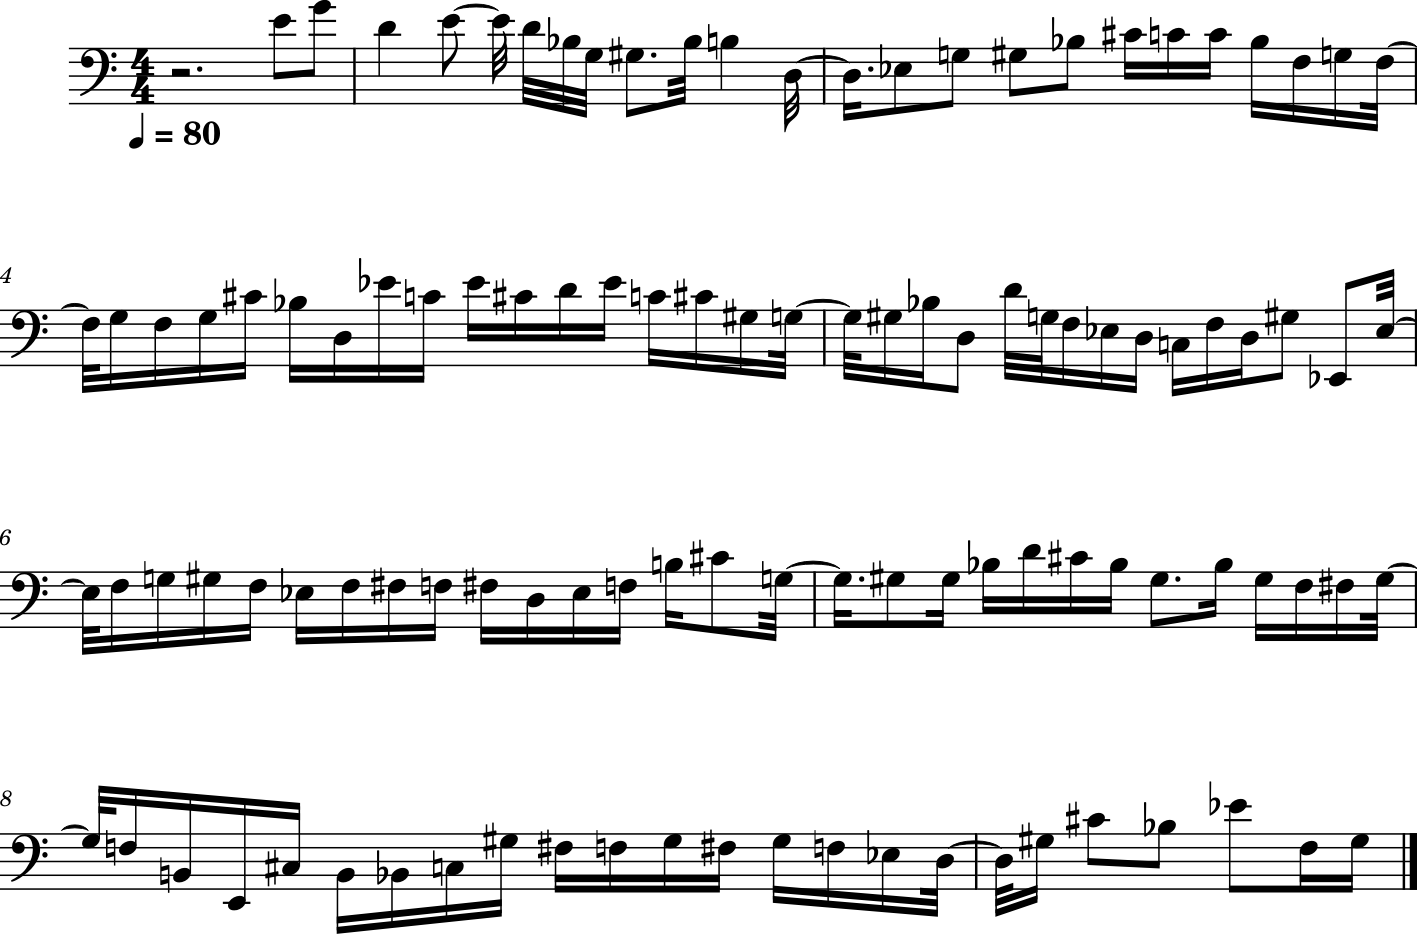

In [270]:
strm = stream.Stream()
mm = tempo.MetronomeMark(number=80)  # BPM = 80
strm.append(mm)  # tempo
strm.append(instrument.Violoncello())  # instrument
strm.append(meter.TimeSignature('4/4')) # time signature
n = note.Rest()
n.duration.quarterLength = onset/8
strm.append(n)
for i in range(len(Gen)):
    n = note.Note()
    n.pitch.midi = Gen['Note'][i]
    n.duration.quarterLength = Gen['Duration_32th'][i]/8
    strm.append(n)
strm.show()

In [271]:
strm.show('mid')

We can also write it to a MIDI file. The MIDI file is unified under parameters below:
- PPQ: 480
- BPM: 80 (Tempo: 750000)
- Time signature: 4/4
- Instrument: cello (Program_c: 42)

In [111]:
PPQ = 480
PP32 = int(PPQ/8)
PP32

60

In [112]:
time = int(onset * PP32)
time

240

In [265]:
generated_csv = open("midi.csv", 'w')
generated_csv.write("0,0,Header,0,1,480\n")
generated_csv.write("1,0,Start_track\n")
generated_csv.write("1,0,Tempo,750000\n")
generated_csv.write("1,0,Time_signature,4,2,24,8\n")
generated_csv.write("1,0,Program_c, 0, 42\n")

for i in range(len(Gen)):
    note = Gen['Note'][i]
    level = Gen['Structure_level'][i]
    if level == 0:
        velocity = np.random.randint(100,115)
    elif level == 1:
        velocity = np.random.randint(90,105)
    elif level == 2:
        velocity = np.random.randint(80,95)
    else:
        velocity = np.random.randint(75-5*(level-3),85-5*(level-3))
        
    generated_csv.write("1,"+str(time)+",Note_on_c,0,"+str(note)+","+str(velocity)+"\n")
    time += int(Gen['Duration_32th'][i]*PP32)
    generated_csv.write("1,"+str(time)+",Note_on_c,0,"+str(note)+",0\n")

end_time = time + PPQ
generated_csv.write("1," + str(end_time) +", End_track\n")
generated_csv.write("0, 0, End_of_file")
generated_csv.close()

In [266]:
# Parse the CSV output of the previous command back into a MIDI file
midi_object = pm.csv_to_midi("midi.csv")

# Save the parsed MIDI file to disk
with open("C://Users/79244/Desktop/generated.mid", "wb") as output_file:
    midi_writer = pm.FileWriter(output_file)
    midi_writer.write(midi_object)

### 6) Comments

The music generation task is overly simplified in our case. The real musical phenomenon is far more complex than concatenating single notes. Take a look at the following file,

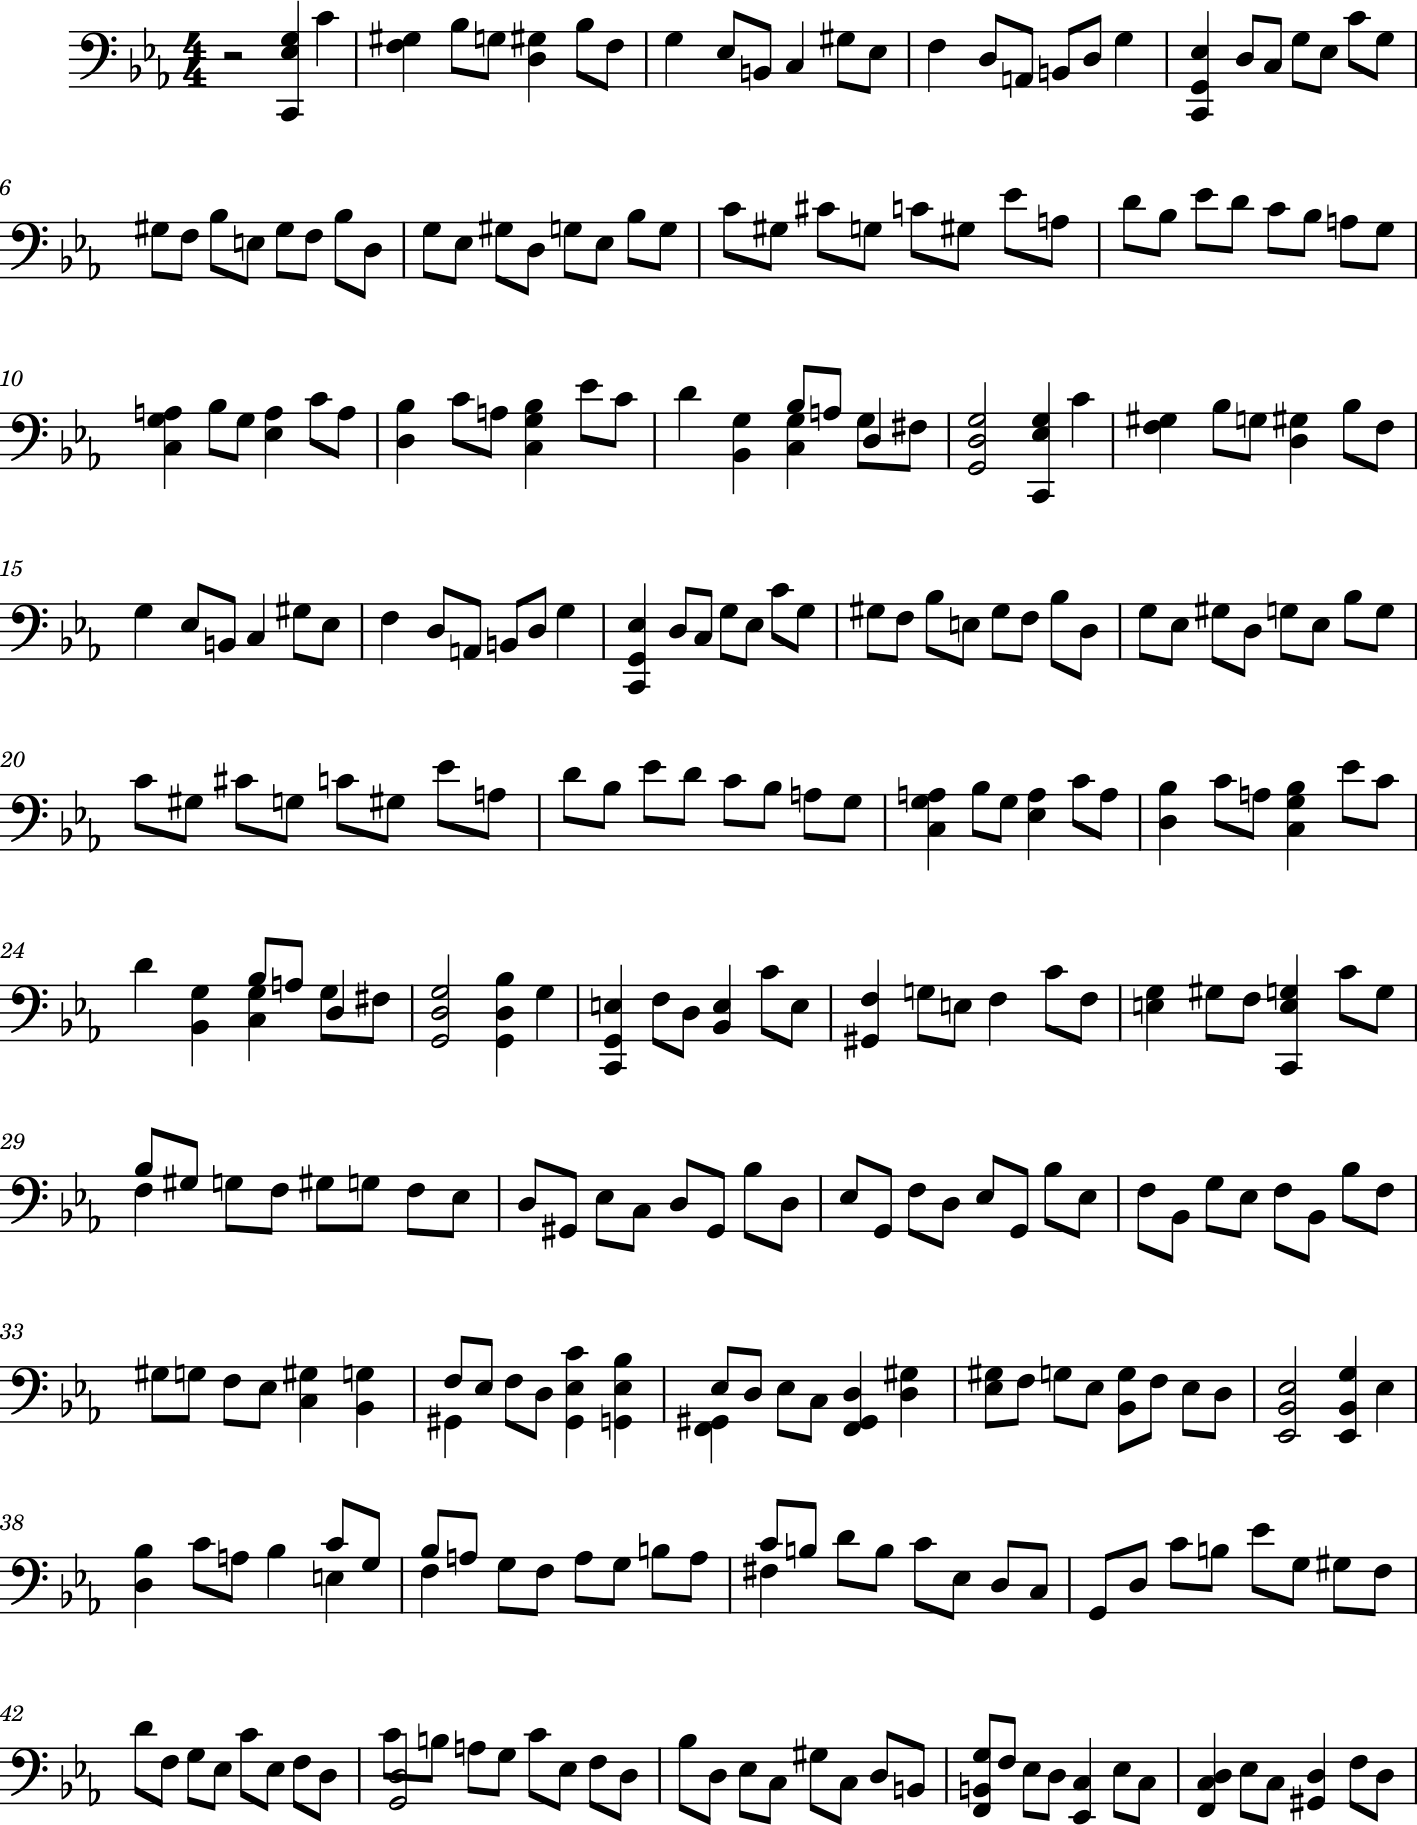

In [114]:
s = converter.parse("Music\cs5-5polyphony.mid")
s.show()

In [115]:
s.show('mid')

The building blocks for music are chords rather than notes, and the interplay between different parts, the emotional convey and expressivity of music, the acoustic scene the sounds created are far way beyond what we have covered. To generate such complicated music, we need more advanced design of the systems and a better way of data processing. Do you have any inspirations or ideas? We are looking forward to reading your project and discussing your practices!